In [1]:
# https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb#:~:text=Binary%20Classification%20Using%20Convolution%20Neural%20Network%20(CNN)%20Model,-Mayank%20Verma&text=Binary%20classification%20is%20used%20in,like%20Color%2C%20weight%2C%20etc.
# https://www.kaggle.com/code/mostafizur1997/binary-image-classification-using-cnn
# https://ieeexplore.ieee.org/document/7394333

# https://github.com/pandeydivyank/SAR-Image-segmentation/tree/master

import rasterio
import numpy as np
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [2]:
# input_sar_image_path  = "../MachineLearning/input/eaton_s1_ready.tif"
# input_label_image_path="input/eaton_dnbr_label.tif"
# output_model_path="output/model/unet_model_eaton.h5"

input_sar_image_path  = "../MachineLearning/input/palisades_s1_ready.tif"
input_label_image_path="input/palisades_dnbr_label.tif"
output_model_path="output/model/unettt_model_palisades_256.h5"

In [3]:
# Load input image (tif)
with rasterio.open(input_sar_image_path) as src:
    input_image = src.read([1, 2, 3,4])  # Read all RGB bands (assuming 3 bands)
    input_image = np.moveaxis(input_image, 0, -1)  # Shape: (height, width, channels)

# Load label image (tif)
with rasterio.open(input_label_image_path) as src:
    label_image = src.read(1)  # Assuming the label is a single band
    meta = src.meta.copy()

In [4]:
patch_size =  256  # Size of each patch (64x64 pixels), 32
stride = 255  # Stride for moving the patch across the image, 14
# patch_size = 64  # Size of each patch (64x64 pixels)
# stride = 32  # Stride for moving the patch across the image

def extract_patches(image, label, patch_size, stride):
    patches = []
    label_patches = []
    height, width, _ = image.shape
    for y in range(0, height - patch_size, stride):
        for x in range(0, width - patch_size, stride):
            patch = image[y:y + patch_size, x:x + patch_size, :]
            label_patch = label[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            label_patches.append(label_patch)
    return np.array(patches), np.array(label_patches)

# Extract patches from both input image and label image
X_patches, y_patches = extract_patches(input_image, label_image, patch_size, stride)

print(X_patches.shape)


(91, 256, 256, 4)


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_patches, y_patches, test_size=0.30, random_state=42)
# Split the remaining data into validation and testing sets (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_train = np.expand_dims(y_train, axis=-1)
y_val=np.expand_dims(y_val, axis=-1)
y_test=np.expand_dims(y_test, axis=-1)
print(f"Train data: {X_train.shape}")
print(f"train label data: {y_train.shape}")

print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")


Train data: (63, 256, 256, 4)
train label data: (63, 256, 256, 1)
Validation data: (14, 256, 256, 4)
Test data: (14, 256, 256, 4)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pixel-wise attention mechanism (with Conv2D and sigmoid activation)
def pixel_attention(input_tensor):
    attention_weights = layers.Conv2D(1, (1, 1), activation='sigmoid')(input_tensor)
    attention_weights = layers.Multiply()([input_tensor, attention_weights])
    return attention_weights

# U-Net architecture with pixel-wise attention
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder with Pixel-wise Attention
    up5 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv4)
    concat5 = layers.concatenate([up5, conv3])
    attention5 = pixel_attention(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(attention5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv2])
    attention6 = pixel_attention(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(attention6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv1])
    attention7 = pixel_attention(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(attention7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs, outputs)
    return model

# Define learning rate schedule
def lr_schedule(epoch):
    if epoch < 20:
        return 0.001
    elif epoch < 40:
        return 0.0005
    else:
        return 0.0001

# Compile the model
input_shape = (256, 256, 4)  # Example input shape
model = unet_model(input_shape)
model.summary()

# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Data Augmentation setup
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.0,
#     horizontal_flip=True,
#     vertical_flip=True
# )

# # Example training data (replace with actual dataset)
# train_generator = train_datagen.flow_from_directory(
#     'path/to/training_data',
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode='binary'
# )

# # Train the model with the learning rate schedule callback
# callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# history = model.fit(
#     train_generator,
#     epochs=60,
#     callbacks=[callback]
# )







Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64, 1) │        513 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ concatenate[0][0… │
│                     │ 512)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ multiply[0][0]    │
│                     │ 256)              │            │                 

 Total params: 8,558,980 (32.65 MB)

 Trainable params: 8,558,980 (32.65 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 13s/step - accuracy: 0.9722 - loss: 0.6510 - val_accuracy: 0.9913 - val_loss: 0.3973
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 14s/step - accuracy: 0.9880 - loss: 0.4861 - val_accuracy: 0.9913 - val_loss: 0.2166
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2125s 704s/step - accuracy: 0.9881 - loss: 0.1670 - val_accuracy: 0.9913 - val_loss: 0.1326
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5182s 1026s/step - accuracy: 0.9907 - loss: 0.2993 - val_accuracy: 0.9913 - val_loss: 0.0704
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5877s 1653s/step - accuracy: 0.9907 - loss: 0.1156 - val_accuracy: 0.9913 - val_loss: 0.1106
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7845s 1953s/step - accuracy: 0.9880 - loss: 0.1079 - val_accuracy: 0.9913 - val_loss: 0.0629
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2241s 626s/step - accuracy: 0.9909 - loss: 0.0744 - val_accuracy: 0.9913 - val_loss: 0.0672
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.9894 - loss: 0.0861 - val_accuracy: 0.9913 -

In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9991 - loss: 0.0146
Test Accuracy: 0.9991389513015747


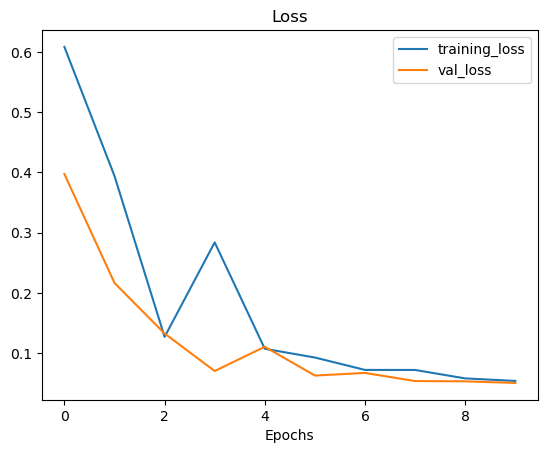

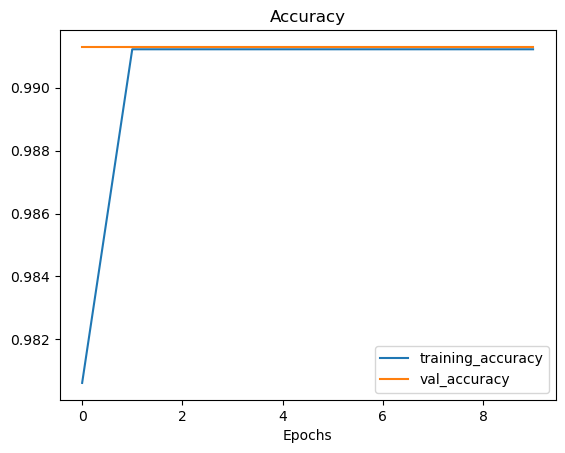

In [19]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(history)

In [10]:
# import numpy as np
# from tensorflow.image import extract_patches

# def extract_image_patches(image, patch_size=(patch_size, patch_size), stride=stride):
#     """
#     Extracts patches from an image.
    
#     Args:
#     - image (numpy array): Input image of shape (H, W, C)
#     - patch_size (tuple): Size of each patch (height, width)
#     - stride (int): Step size for moving window
    
#     Returns:
#     - patches (numpy array): Extracted patches (num_patches, patch_size, patch_size, C)
#     """
#     H, W, C = image.shape
#     patch_H, patch_W = patch_size

#     # Compute number of patches
#     num_patches_H = (H - patch_H) // stride + 1
#     num_patches_W = (W - patch_W) // stride + 1

#     patches = []

#     for i in range(0, H - patch_H + 1, stride):
#         for j in range(0, W - patch_W + 1, stride):
#             patch = image[i:i + patch_H, j:j + patch_W, :]
#             patches.append(patch)

#     return np.array(patches)



In [11]:
# X_patches = extract_image_patches(input_image, patch_size=(patch_size, patch_size), stride=32)

# print("Extracted X_patches shape:", X_patches.shape)

In [12]:
# # Predict on new data (e.g., test set or validation set)
# predictions = model.predict(X_patches)
# binary_predictions = (predictions > 0.5).astype(np.uint8)
# # class_predictions = np.argmax(binary_predictions, axis=-1)  # Shape: (1409, 64, 64)
# print(binary_predictions.shape)


In [13]:
# import matplotlib.pyplot as plt
# def reconstruct_from_patches(patches, image_size, patch_size=(patch_size, patch_size), stride=32):
#     H, W = image_size
#     patch_H, patch_W = patch_size
#     full_image = np.zeros((H, W, 1))  # Assuming single-channel output

#     idx = 0
#     for i in range(0, H - patch_H + 1, stride):
#         for j in range(0, W - patch_W + 1, stride):
#             full_image[i:i + patch_H, j:j + patch_W, :] = patches[idx]
#             idx += 1

#     return full_image

# # Reconstruct full predicted mask
# predicted_mask = reconstruct_from_patches(predictions, input_image.shape[:2])

# # Visualize the final prediction
# plt.imshow(predicted_mask.squeeze(), cmap='gray')
# plt.title('Full Predicted Mask')
# plt.axis('off')
# plt.show()


In [14]:
# with rasterio.open("image_reconstruct.tiff", 'w') as dest:
#         # clipped_data = dataset.read(i+1, window=window)
#         dest.write(predicted_mask, 1)
# import tifffile as tiff
# # Save as TIFF
# tiff.imwrite("predicted_mask.tiff", predicted_mask.astype(np.float32))

In [15]:
# Define metadata for rasterio
# output_image_path = "predicted_mask.tif"

# meta = {
#     "driver": "GTiff",
#     "dtype": predicted_mask.dtype,
#     "count": 1,  # Single-band image
#     "height": predicted_mask.shape[0],
#     "width": predicted_mask.shape[1],
#     "crs": "EPSG:4326",  # Change CRS if needed
#     # "transform": from_origin(0, 0, 1, 1)  # Modify transform if georeferenced data
# }

# Save as TIFF with metadata
# with rasterio.open(output_image_path, 'w', **meta) as dest:
#     dest.write(predicted_mask, 1)  # Write the image as band 1

# print(f"TIFF file saved with metadata at {output_image_path}")

In [16]:
# from tensorflow import keras
# from tensorflow.keras import datasets, layers, models
# from keras.models import Sequential
# # from keras.layers.core import Flatten, Dense, Dropout
# # from keras.layers.convolutional import Convolution2D, MaxPooling2D
# #creating convolutional model

# model = models.Sequential()

# model.add(layers.Conv2D(64, (3, 3), activation='relu',
#                         input_shape=(363, 358, 3)))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
# model.add(layers.Dense(2, activation='softmax'))

# model.summary()

In [20]:
model.save(output_model_path)
